# Proyek Analisis Data: PRSA Data Changping dan PRSA Data Dongsi
- **Nama:** Favian Hilmi Putradifa
- **Email:** favianhilmi11@gmail.com
- **ID Dicoding:** A180YBM165

## Menentukan Pertanyaan Bisnis

- Pada jam berapa kualitas udara di Kota Changping dan Dongsi memburuk dari biasanya?
- Bagaimana pola perubahan kualitas udara berdasarkan musim atau hari dalam seminggu?

## Import Semua Packages/Library yang Digunakan

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Wrangling

### Gathering Data

In [3]:
# Dataset yang digunakan
changping_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PRSA_Data_Changping.csv", sep=";", low_memory=False)
dongsi_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PRSA_Data_Dongsi.csv", sep=";", low_memory=False)

# Menggabungkan dataset
df_combined = pd.concat([changping_df, dongsi_df], ignore_index=True)

# Convert kolom menjadi datetime
df_combined["datetime"] = pd.to_datetime(df_combined[["year", "month", "day", "hour"]])

print(df_combined.info())
print(df_combined.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   No        70128 non-null  int64         
 1   year      70128 non-null  int64         
 2   month     70128 non-null  int64         
 3   day       70128 non-null  int64         
 4   hour      70128 non-null  int64         
 5   PM2.5     68604 non-null  float64       
 6   PM10      68993 non-null  float64       
 7   SO2       68837 non-null  object        
 8   NO2       67860 non-null  object        
 9   CO        65410 non-null  float64       
 10  O3        68860 non-null  object        
 11  TEMP      70055 non-null  object        
 12  PRES      70058 non-null  object        
 13  DEWP      70055 non-null  float64       
 14  RAIN      70057 non-null  float64       
 15  wd        69910 non-null  object        
 16  WSPM      70071 non-null  float64       
 17  station   70

### **1. Dataset Overview**  
Menggunakan 2 dataset kualitas udara dari 2 lokasi berbeda:
- Dataset pengukuran kualitas udara Kota Changping
- Dataset pengukuran kualitas udara Kota Dongsi

### **2. Konversi kolom waktu menjadi Datetime**
Dataset memiliki informasi waktu dalam beberapa kolom (year, month, day, hour). Untuk mempermudah analisis, kolom tersebut dikonversi menjadi 1 kolom datetime.

### Assessing Data

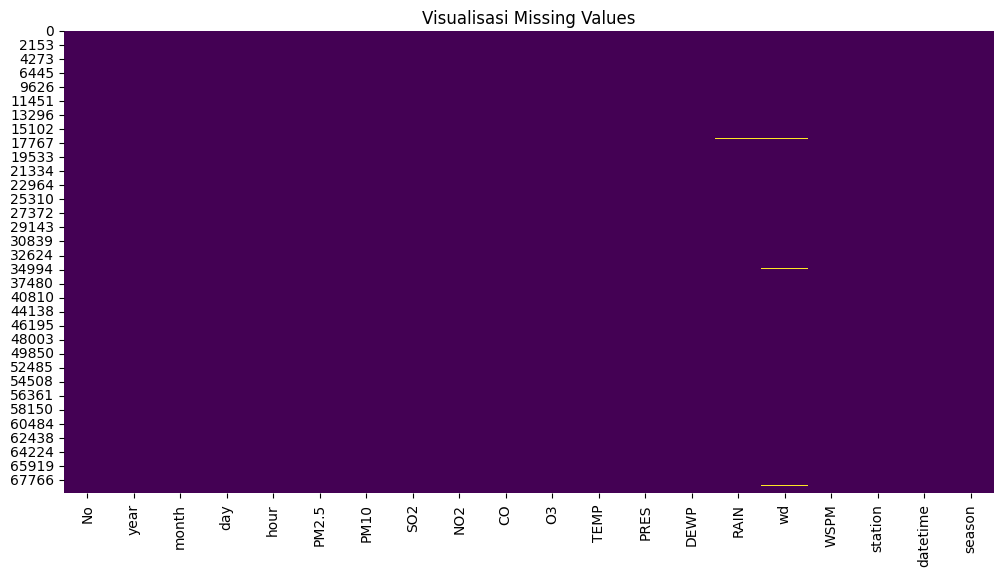

Missing Value Checking
PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
WSPM     0
dtype: int64


In [11]:
selected_columns = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "WSPM" ]

existing_columns = [col for col in selected_columns if col in df_combined.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(df_combined.isnull(), cmap="viridis", cbar=False)
plt.title("Visualisasi Missing Values")
plt.show()

print("Missing Value Checking")
print(df_combined[existing_columns].isnull().sum())

In [5]:
print("Duplicate Data Checking")
print(df_combined.duplicated().sum())

Duplicate Data Checking
0


Detect Outlier dengan IQR
Kolom yang ada dalam DataFrame: ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM']


Cek tipe data
 PM2.5    float64
PM10     float64
SO2       object
NO2       object
CO       float64
O3        object
TEMP      object
PRES      object
DEWP     float64
WSPM     float64
dtype: object
PM2.5    float64
PM10     float64
SO2       object
NO2       object
CO       float64
O3        object
TEMP      object
PRES      object
DEWP     float64
WSPM     float64
dtype: object


setelah processing
 PM2.5    float64
PM10     float64
SO2      float64
NO2      float64
CO       float64
O3       float64
TEMP     float64
PRES     float64
DEWP     float64
WSPM     float64
dtype: object


Cek Outlier pada Dataframe
PM2.5    3227
PM10     2577
SO2      5697
NO2      2532
CO       4550
O3       3580
TEMP        4
PRES        0
DEWP        0
WSPM     4446
dtype: int64


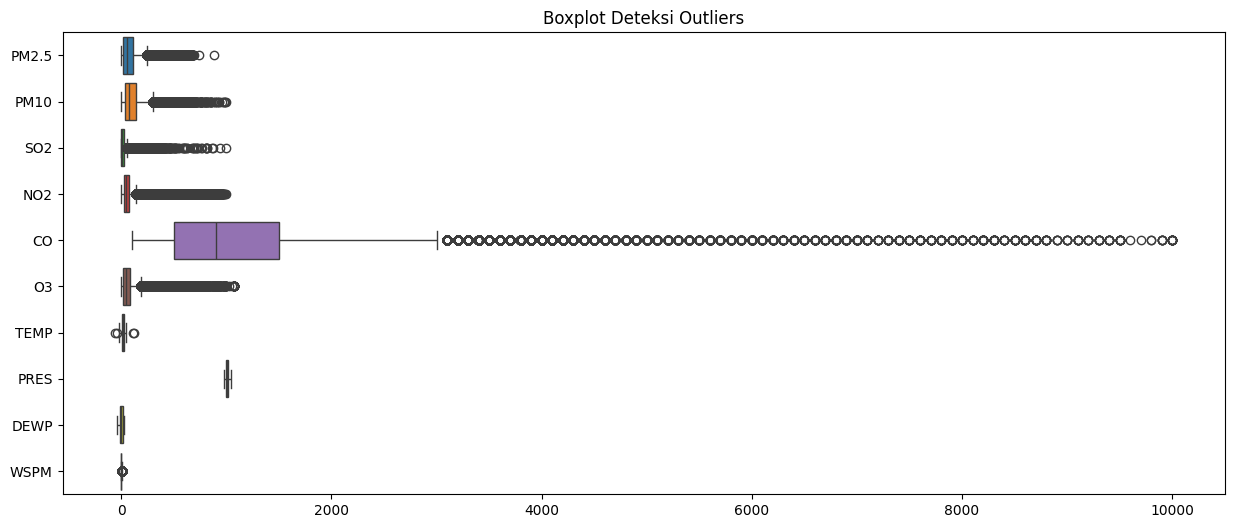

In [6]:
print("Detect Outlier dengan IQR")

selected_columns = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "WSPM" ]
existing_columns = [col for col in selected_columns if col in df_combined.columns]
print(f"Kolom yang ada dalam DataFrame: {existing_columns}")
print("\n")

# Cek tipe data seluruh kolom
print("Cek tipe data\n",df_combined[existing_columns].dtypes)
print(df_combined[existing_columns].dtypes)
df_combined[existing_columns] = df_combined[existing_columns].apply(pd.to_numeric, errors='coerce')
print("\n")
print("setelah processing\n",df_combined[existing_columns].dtypes)
print("\n")

# Cek outlier
print("Cek Outlier pada Dataframe")
Q1 = df_combined[existing_columns].quantile(0.25)
Q3 = df_combined[existing_columns].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_combined[existing_columns] < (Q1 - 1.5 * IQR)) |
            (df_combined[existing_columns] > (Q3 + 1.5 * IQR))).sum()

print(outliers)


plt.figure(figsize=(15, 6))
sns.boxplot(data=df_combined[existing_columns].select_dtypes(include=['number']), orient='h')
plt.title("Boxplot Deteksi Outliers")
plt.show()


**Insight:**

### **1. Pengecekan Missing Value**  
- Dilakukan untuk mengetahui apakah ada nilai yang hilang (Nan)
- Dicek menggunakan function `".isnull().sum()"`

### **2. Pengecekan Data Duplikat**  
- Dilakukan untuk mengetahui data duplikat yang dapat mempengaruhi hasil analisis
- Dicek menggunakan function `".duplicated().sum()"`

### **3. Pengecekan Outlier**  
Dilakukan untuk memastikan tidak ada nilai ekstrem, menggunakan metode IQR :
- **Q1 (kuartil 1):** nilai persentil ke-25  
- **Q3 (kuartil 3):** nilai persentil ke-75  
- **IQR (interquartile range):** selisih antara Q3 dan Q1  

Data dianggap sebagai outlier jika berada di luar rentang:

\[
Q1 - 1.5 \times IQR
\]
atau
\[
Q3 + 1.5 \times IQR
\]


### Cleaning Data

In [7]:
# Mengatasi Missing Value
df_combined[existing_columns] = df_combined[existing_columns].fillna(df_combined[existing_columns].mean())

# Mengatasi Outlier
for col in existing_columns:
  Q1 = df_combined[col].quantile(0.25)
  Q3 = df_combined[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # df_combined[col] = df_combined[col].apply(lambda x: df_combined[col].median() if x < lower_bound or x > upper_bound else x)
  df_combined = df_combined[(df_combined[col] >= lower_bound) & (df_combined[col] <= upper_bound)]
# Menampilkan informasi data setelah proses cleaning
print(df_combined.info())


<class 'pandas.core.frame.DataFrame'>
Index: 49545 entries, 0 to 70127
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   No        49545 non-null  int64         
 1   year      49545 non-null  int64         
 2   month     49545 non-null  int64         
 3   day       49545 non-null  int64         
 4   hour      49545 non-null  int64         
 5   PM2.5     49545 non-null  float64       
 6   PM10      49545 non-null  float64       
 7   SO2       49545 non-null  float64       
 8   NO2       49545 non-null  float64       
 9   CO        49545 non-null  float64       
 10  O3        49545 non-null  float64       
 11  TEMP      49545 non-null  float64       
 12  PRES      49545 non-null  float64       
 13  DEWP      49545 non-null  float64       
 14  RAIN      49492 non-null  float64       
 15  wd        49391 non-null  object        
 16  WSPM      49545 non-null  float64       
 17  station   49545 n

**Insight:**

### **1. Mengatasi Missing Values**
Missing values diatasi dengan metode **imputasi menggunakan mean**, yang mana nilai yang hilang akan diisi dengan rata-rata dari kolom tersebut

### **2. Mengatasi Outlier**
Outlier diatasi menggunakan metode Interquartile Range (IQR) dengan cara mengganti nilai outlier dengan nilai median.

- Q1 (Kuartil 1): Nilai persentil ke-25
- Q3 (Kuartil 3): Nilai persentil ke-75
- IQR (Interquartile Range): Selisih antara Q3 dan Q1
- Lower Bound: Q1-1.5 x IQR
- Upper Bound: Q3 + 1.5 X IQR

Jika terdapat data yang nilainya berada di luar batas, maka akan diganti dengan median dari kolom tersebut.


## Exploratory Data Analysis (EDA)

### Explore ...

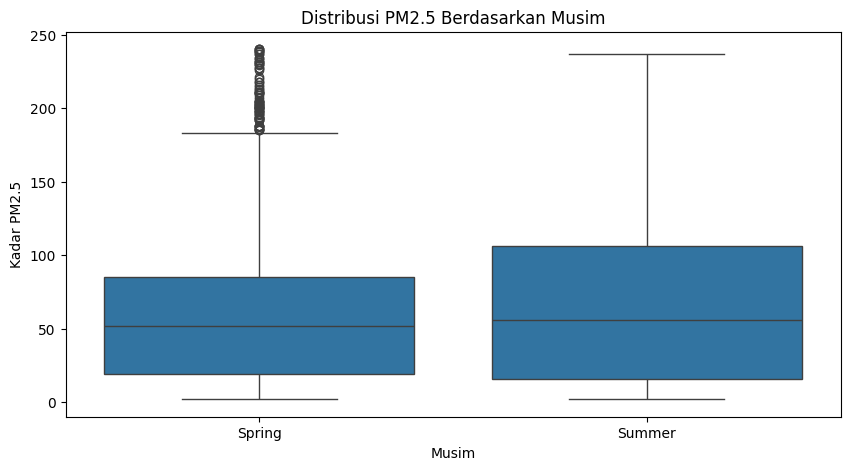

<ipython-input-10-53d4f5868348>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["day_of_week"] = df_filtered["datetime"].dt.day_name()


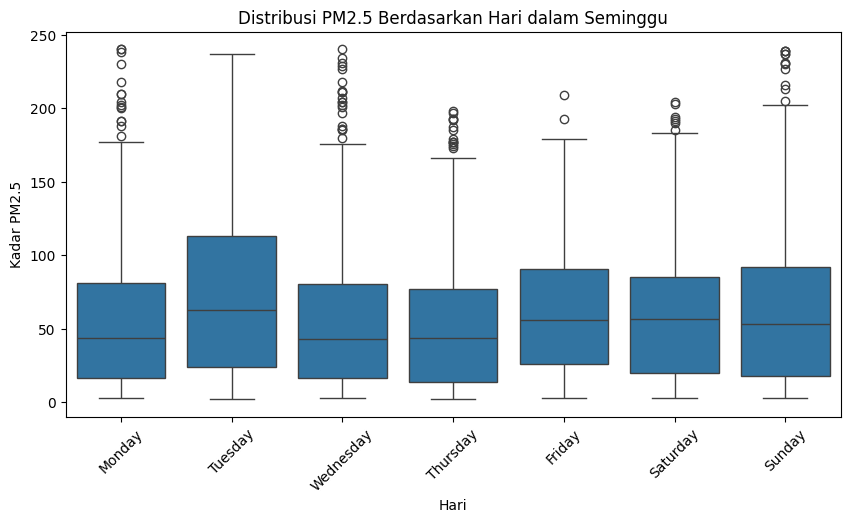

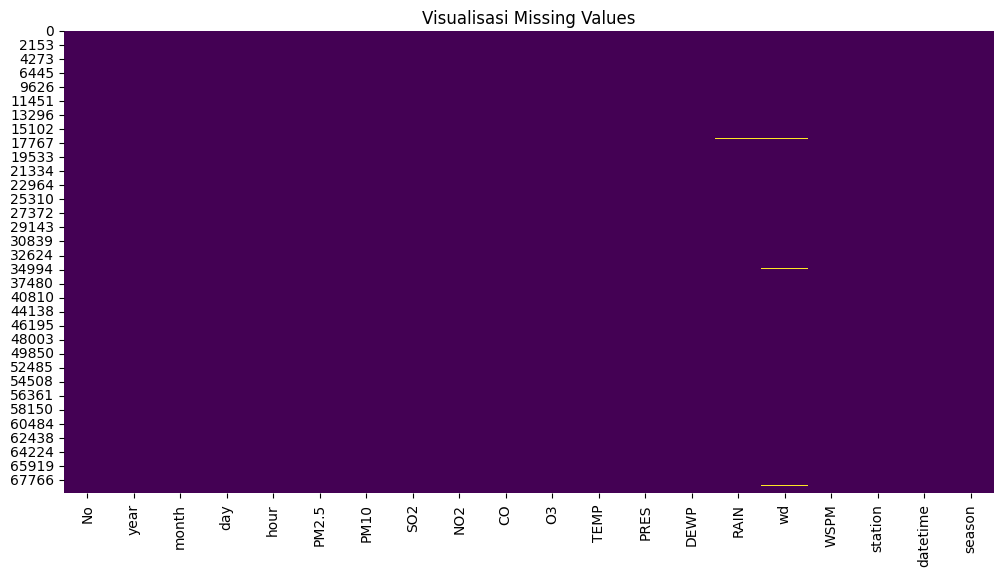

Jumlah Missing Value No            0
year          0
month         0
day           0
hour          0
PM2.5         0
PM10          0
SO2           0
NO2           0
CO            0
O3            0
TEMP          0
PRES          0
DEWP          0
RAIN         53
wd          154
WSPM          0
station       0
datetime      0
season        0
dtype: int64


In [10]:
# Pastikan kolom datetime dalam format yang benar
df_combined["datetime"] = pd.to_datetime(df_combined["datetime"])

# Menentukan musim berdasarkan bulan
season_map = {12: "Winter", 1: "Winter", 2: "Winter",
              3: "Spring", 4: "Spring", 5: "Spring",
              6: "Summer", 7: "Summer", 8: "Summer",
              9: "Fall", 10: "Fall", 11: "Fall"}

df_combined["season"] = df_combined["month"].map(season_map)

# **FILTER BERDASARKAN RENTANG WAKTU**
start_year, start_month = 2013, 1  # Tahun A, Bulan A
end_year, end_month = 2013, 6  # Tahun B, Bulan B

start_date = datetime(start_year, start_month, 1)
end_date = datetime(end_year, end_month, 28)  # Untuk Februari tetap aman

df_filtered = df_combined[(df_combined["datetime"] >= start_date) &
                          (df_combined["datetime"] <= end_date)]

# **VISUALISASI 1: Distribusi PM2.5 Berdasarkan Musim**
plt.figure(figsize=(10, 5))
sns.boxplot(x="season", y="PM2.5", data=df_filtered)
plt.title("Distribusi PM2.5 Berdasarkan Musim")
plt.xlabel("Musim")
plt.ylabel("Kadar PM2.5")
plt.show()

# **VISUALISASI 2: Distribusi PM2.5 Berdasarkan Hari dalam Seminggu**
df_filtered["day_of_week"] = df_filtered["datetime"].dt.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(x="day_of_week", y="PM2.5", data=df_filtered,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Distribusi PM2.5 Berdasarkan Hari dalam Seminggu")
plt.xlabel("Hari")
plt.ylabel("Kadar PM2.5")
plt.xticks(rotation=45)
plt.show()

# **VISUALISASI 3: Tren Kualitas Udara terhadap Ketinggian (PRES)**
# Pilih data untuk satu musim (misalnya Winter)
winter_df = df_filtered[df_filtered["season"] == "Winter"]

# Parameter polusi yang ingin dianalisis
air_quality_params = ["PM2.5", "PM10", "SO2", "NO2", "O3"]

# Ubah format data agar cocok untuk seaborn
winter_melted = winter_df.melt(id_vars=["PRES"], value_vars=air_quality_params,
                               var_name="Air Quality Parameter", value_name="Value")

# plt.figure(figsize=(12, 6))
# sns.lineplot(x="PRES", y="Value", hue="Air Quality Parameter", data=winter_melted, marker="o")
# plt.title("Tren Kualitas Udara terhadap Tingkat Ketinggian (PRES) di Musim Winter")
# plt.xlab





**Insight:**

### **1. Filter Data**
Data difilter berdasarkan rentang waktu yang telah ditentukan (misalnya, dari tahun 2013 hingga tahun 2015

### **2. Visualisasi Distribusi PM2.5**
Boxplot dibuat untuk memvisualisasikan distribusi PM2.5 berdasarkan musim.

Boxplot juga dibuat untuk memvisualisasikan distribusi PM2.5 berdasarkan hari dalam seminggu.


### **3. Analisis Tren Kualitas Udara terhadap Ketinggian**
Melting digunakan untuk mengubah format data agar sesuai untuk visualisasi tren parameter kualitas udara (PM2.5, PM10, SO2, NO2, O3) terhadap tingkat ketinggian (PRES)

## Visualization & Explanatory Analysis

### Pertanyaan 1:

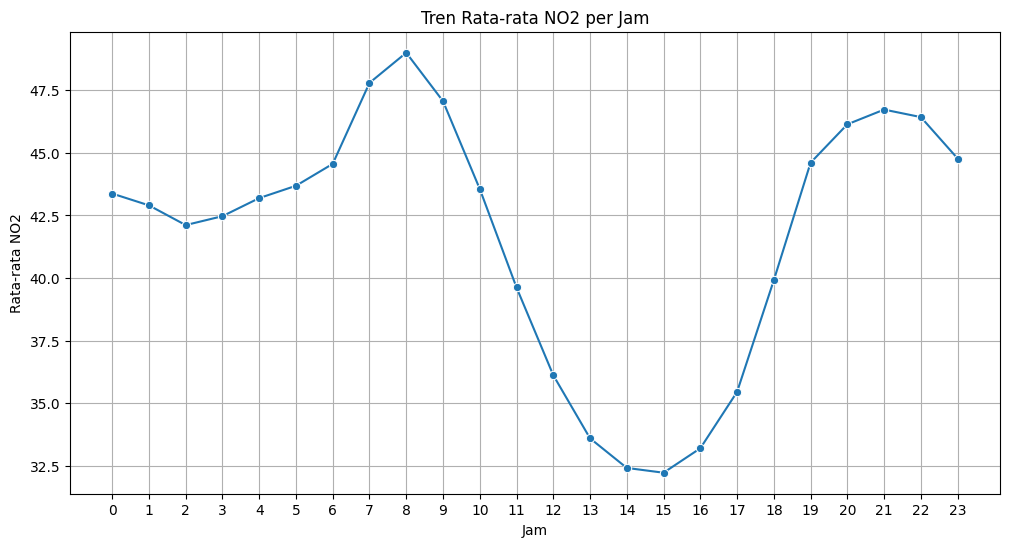

Kualitas udara terburuk terjadi pada jam 8 dengan rata-rata NO2: 49.00


In [14]:
# Pilih parameter kualitas udara (misalnya, PM2.5)
selected_param = "NO2"

# Hitung rata-rata parameter per jam
avg_hourly = df_combined.groupby(df_combined["datetime"].dt.hour)[selected_param].mean()

# Visualisasi tren per jam
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_hourly.index, y=avg_hourly.values, marker='o')
plt.title(f"Tren Rata-rata {selected_param} per Jam")
plt.xlabel("Jam")
plt.ylabel(f"Rata-rata {selected_param}")
plt.xticks(range(24))  # Set ticks untuk setiap jam
plt.grid(True)
plt.show()

# Tampilkan jam dengan kualitas udara terburuk
worst_hour = avg_hourly.idxmax()
worst_value = avg_hourly.max()
print(f"Kualitas udara terburuk terjadi pada jam {worst_hour} dengan rata-rata {selected_param}: {worst_value:.2f}")

### Pertanyaan 2:

<ipython-input-17-26a31b915c3e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_combined, x="season", y=selected_param, palette="viridis")


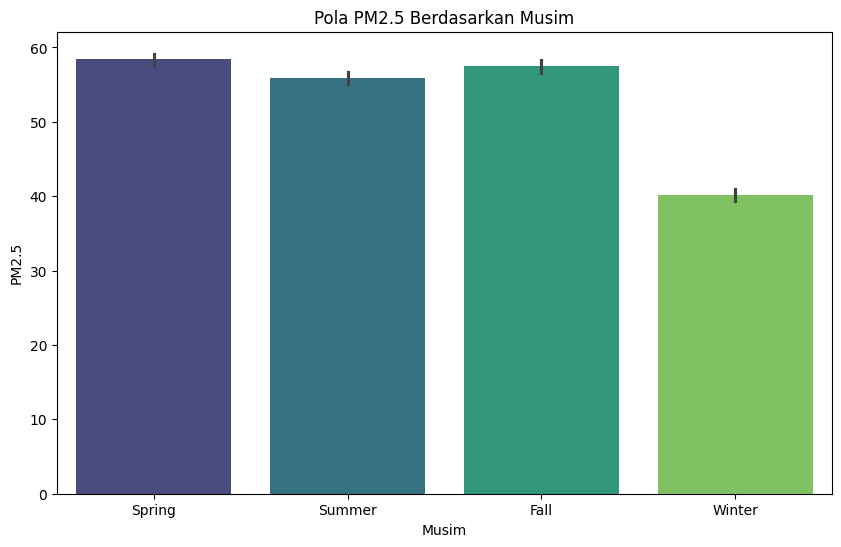


Rata-rata  PM2.5 berdasarkan musim:
season
Spring    58.424907
Fall      57.455952
Summer    55.942482
Winter    40.177333
Name: PM2.5, dtype: float64

Kesimpulan: Kadar PM2.5 cenderung paling tinggi pada musim Spring.


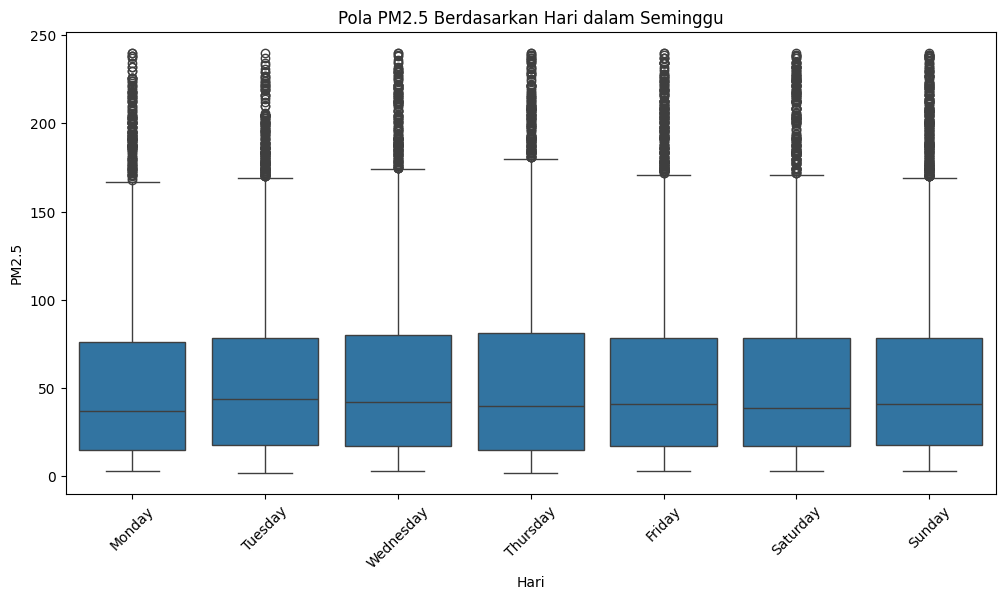


Rata-rata  PM2.5 berdasarkan hari dalam seminggu:
day_of_week
Monday       49.986888
Tuesday      54.435599
Wednesday    54.695160
Thursday     55.617606
Friday       54.672817
Saturday     53.431440
Sunday       54.613023
Name: PM2.5, dtype: float64

Kesimpulan: Kadar PM2.5 cenderung paling tinggi pada hari Thursday.


In [17]:
# Pilih parameter kualitas udara
selected_param = "PM2.5"

# Mapping musim
season_map = {12: "Winter", 1: "Winter", 2: "Winter", 3: "Spring", 4: "Spring", 5: "Spring",
              6: "Summer", 7: "Summer", 8: "Summer", 9: "Fall", 10: "Fall", 11: "Fall"}
df_combined["season"] = df_combined["month"].map(season_map)

# Tambahkan kolom day_of_week
df_combined["day_of_week"] = df_combined["datetime"].dt.day_name()

# Visualisasi pola musiman
plt.figure(figsize=(10, 6))
sns.barplot(data=df_combined, x="season", y=selected_param, palette="viridis")
plt.title(f"Pola {selected_param} Berdasarkan Musim")
plt.xlabel("Musim")
plt.ylabel(selected_param)
plt.show()

# Kesimpulan pola musiman
seasonal_avg = df_combined.groupby('season')[selected_param].mean().sort_values(ascending=False)
print("\nRata-rata ", selected_param, "berdasarkan musim:")
print(seasonal_avg)

most_polluted_season = seasonal_avg.index[0]
print(f"\nKesimpulan: Kadar {selected_param} cenderung paling tinggi pada musim {most_polluted_season}.")


# Visualisasi pola harian
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x="day_of_week", y=selected_param, order=day_order)
plt.title(f"Pola {selected_param} Berdasarkan Hari dalam Seminggu")
plt.xlabel("Hari")
plt.ylabel(selected_param)
plt.xticks(rotation=45)
plt.show()

# Kesimpulan pola harian
daily_avg = df_combined.groupby('day_of_week')[selected_param].mean().reindex(day_order)
print("\nRata-rata ", selected_param, "berdasarkan hari dalam seminggu:")
print(daily_avg)

most_polluted_day = daily_avg.idxmax()
print(f"\nKesimpulan: Kadar {selected_param} cenderung paling tinggi pada hari {most_polluted_day}.")

**Insight:**

### **1. Penghitungan Rata-rata Parameter Kualitas Udara per Jam**
Parameter kualitas udara yang dipilih adalah NO2, namun dapat disesuaikan dengan mengganti parameter pada `selected_param`.
- Rata-rata kadar polutan dihitung per jam menggunakan fungsi `groupby()` dan `mean()`.
- Hasil rata-rata divisualisasikan dengan menggunakan line plot, menunjukkan tren kadar polutan sepanjang hari.

### **2. Identifikasi Jam dengan Kualitas Udara Terburuk**
- Untuk mengidentifikasi jam yang kadar polutannya bernilai tertinggi  menggunakan `idxmax()` dan nilai maksimum diperoleh dengan `max()`.
- Hasilnya dicetak untuk menunjukkan jam di mana kualitas udara terburuk terjadi.

### **3. Pemetaan Musim dan Penambahan Kolom Hari dalam Seminggu**
- Parameter kualitas udara kedua yang dipilih adalah PM2.5, namun bisa disesuaikan pada `selected_param`
- Musim ditentukan berdasarkan bulan menggunakan mapping yang telah dibuat sebelumnya.
-  Menambahkan kolom `day_of_week` untuk menyimpan nama hari dari kolom datetime.

### **4. Visualisasi Pola Musiman Kadar Polutan**
- Pola kadar polutan berdasarkan musim divisualisasikan menggunakan bar plot.
- Rata-rata kadar polutan dihitung untuk setiap musim dan ditampilkan dalam grafik.
- Musim dengan kadar polutan tertinggi dicetak sebagai kesimpulan.

### **5. Visualisasi Pola Harian Kadar Polutan**
- Pola kadar polutan berdasarkan hari dalam seminggu divisualisasikan menggunakan box plot.
- Urutan hari ditentukan untuk memastikan tampilan yang konsisten.
- Rata-rata kadar polutan dihitung untuk setiap hari dalam seminggu dan diatur sesuai urutan hari.
- Hari dengan kadar polutan tertinggi diidentifikasi dan dicetak sebagai kesimpulan.

## Analisis Lanjutan (Opsional)

<ipython-input-20-cfe672c5e284>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Cluster"] = kmeans.fit_predict(df_scaled)


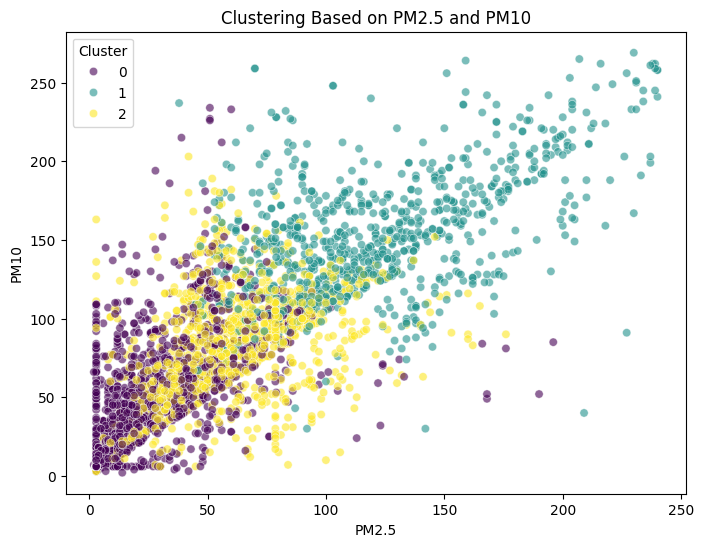

Cluster Distribution:
      station  PM2.5   PM10   SO2   NO2     CO    O3  Cluster
0   Changping    3.0    6.0  13.0   7.0  300.0  85.0        0
1   Changping    3.0    3.0   6.0   6.0  300.0  85.0        0
2   Changping    3.0    3.0  22.0  13.0  400.0  74.0        0
3   Changping    3.0    6.0  12.0   8.0  300.0  81.0        0
4   Changping    3.0    3.0  14.0   8.0  300.0  81.0        0
5   Changping    3.0    3.0  10.0  17.0  400.0  71.0        0
6   Changping    4.0    6.0  12.0  22.0  500.0  65.0        0
7   Changping    3.0    6.0  25.0  39.0  600.0  48.0        0
8   Changping    9.0   25.0  13.0  42.0  700.0  46.0        0
9   Changping   11.0   29.0   5.0  18.0  500.0  73.0        0
10  Changping    9.0   10.0   3.0  10.0  300.0  83.0        0
11  Changping    3.0    3.0   4.0   9.0  300.0  81.0        0
12  Changping    3.0    6.0   4.0   8.0  300.0  90.0        0
13  Changping    3.0  101.0   5.0   9.0  300.0  89.0        0
14  Changping    9.0   60.0   5.0   6.0  300.0  

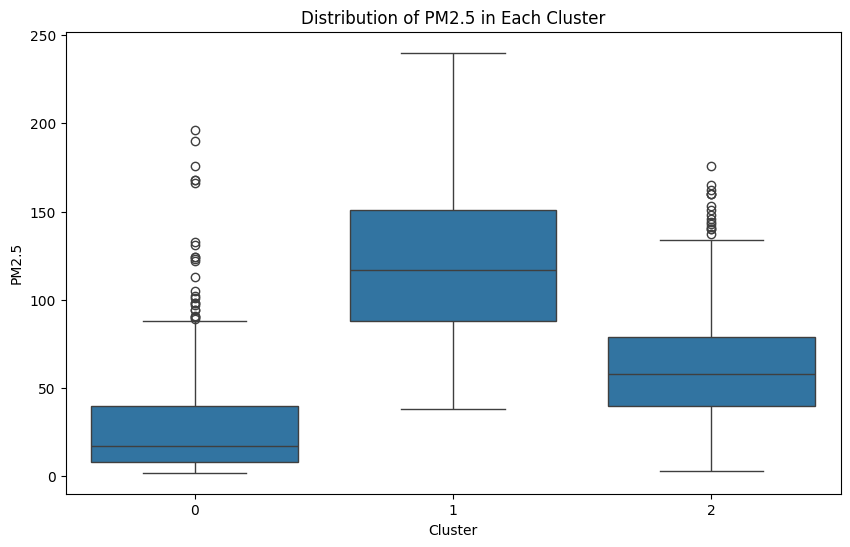

In [20]:
clustering_features = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]
df_clustering = df_filtered[clustering_features].dropna()

# Data scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_filtered["Cluster"] = kmeans.fit_predict(df_scaled)

# Visualizations (using Matplotlib and Seaborn)

# Scatter plot of PM2.5 vs PM10, colored by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_filtered["PM2.5"], y=df_filtered["PM10"], hue=df_filtered["Cluster"], palette="viridis", alpha=0.6)
plt.xlabel("PM2.5")
plt.ylabel("PM10")
plt.title("Clustering Based on PM2.5 and PM10")
plt.show()

# Display cluster distribution
print("Cluster Distribution:")
print(df_filtered[["station", "PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "Cluster"]].head(20))

# Boxplot of PM2.5 distribution in each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_filtered["Cluster"], y=df_filtered["PM2.5"])
plt.title("Distribution of PM2.5 in Each Cluster")
plt.show()

### **1. Penskalaan Data**
- Data dinormalisasi menggunakan `StandardScaler` untuk memastikan bahwa semua fitur memiliki skala yang sama.
- Hasil penskalaan disimpan dalam variabel `df_scaled`.

### **2. K-Means Clustering**
- Algoritma K-Means dipilih untuk mengelompokkan data ke dalam 3 cluster (`n_clusters=3`).
- Parameter `random_state=42` digunakan untuk memastikan hasil yang konsisten pada saat kode dijalankan.
- Hasil clustering ditambahkan ke dataframe `df_filtered` dalam kolom baru bernama **Cluster**.

### **4. Visualisasi Hasil Clustering (Scatter Plot)**
- Scatter plot dibuat untuk memvisualisasikan hubungan antara PM2.5 dan PM10.
- Setiap titik berwarna sesuai dengan cluster yang ditentukan, memberikan gambaran visual tentang distribusi data antar cluster.

### **5. Distribusi Cluster**
- Informasi mengenai distribusi cluster ditampilkan dengan mencetak 20 baris pertama dari dataframe.
- Data ini mencakup informasi stasiun, kadar polutan (PM2.5, PM10, SO2, NO2, CO, O3), dan cluster.

### **6. Visualisasi Distribusi PM2.5 dalam Setiap Cluster**
- Boxplot dibuat untuk menunjukkan distribusi kadar PM2.5 di setiap cluster.
- Visualisasi ini dibuat untuk membantu memahami perbedaan kadar PM2.5 di antara cluster yang telah terbentuk.

## Conclusion

# **Analisis ini bertujuan untuk menjawab dua pertanyaan utama:**

### **Pada jam berapa kualitas udara di Kota Changping dan Dongsi memburuk dari biasanya?**

Ada jam-jam tertentu di kota Changping dan Dongsi yang mana polusi cenderung lebih tinggi. Ini bisa dilihat dengan mencari tahu jam berapa rata-rata kadar polutan (seperti PM2.5) paling tinggi.

### **Bagaimana pola perubahan kualitas udara berdasarkan musim atau hari dalam seminggu?**

### **Musim:**
Kualitas udara dapat berubah tergantung musim. Ada beberapa musim mungkin lebih buruk dari yang lain. Contohnya, musim dingin yang seringkali lebih berpolusi.

### **Hari:**
Kualitas udara juga bisa berbeda di hari-hari yang berbeda dalam seminggu. Mungkin ada hari-hari tertentu di mana polusi lebih tinggi karena aktivitas manusia.

### **Perbandingan Lokasi:**
Jika dibandingkan antara kota Changping dan Dongsi, dapat diidentifikasi apakah salah satu lokasi punya masalah kualitas udara yang lebih besar dari yang lain.

### **Pengelompokan (Clustering):**
Dapat dilakukan pengelompokan data kualitas udara untuk mencari tahu pola-pola tertentu. Hal ini dapat membantu dalan memahami kondisi kualitas udara secara lebih detail.

--------

Analisis ini dapat membantu untuk memahami kapan dan di mana kualitas udara di Changping dan Dongsi paling buruk. Dengan informasi ini, dapat mendukung pengambilan keputusan untuk mengurangi polusi atau membuat kebijakan untuk mengurangi polusi selama musim-musim tertentu.